In [1]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

import torch
import numpy as np
import random
import os
from PIL import Image

from diffusers.utils import load_image
from diffusers import EulerDiscreteScheduler, DDIMScheduler

from photomaker import PhotoMakerStableDiffusionXLPipeline

[i 0716 02:53:14.893360 60 log.cc:351] Load log_sync: 1
[i 0716 02:53:14.978939 60 compiler.py:956] Jittor(1.3.9.5) src: /zhushihao/miniconda3/envs/jdiffusion/lib/python3.9/site-packages/jittor
[i 0716 02:53:14.987422 60 compiler.py:957] g++ at /usr/bin/g++(9.3.0)
[i 0716 02:53:14.989196 60 compiler.py:958] cache_path: /root/.cache/jittor/jt1.3.9/g++9.3.0/py3.9.19/Linux-5.15.0-6x1f/IntelRXeonRPlax9b/2590/default
[i 0716 02:53:14.997941 60 __init__.py:412] Found /usr/local/cuda/bin/nvcc(11.4.120) at /usr/local/cuda/bin/nvcc.
[i 0716 02:53:15.007193 60 __init__.py:412] Found addr2line(2.34) at /usr/bin/addr2line.
[i 0716 02:53:15.180027 60 compiler.py:1011] cuda key:cu11.4.120_sm_86
[i 0716 02:53:15.582705 60 __init__.py:227] Total mem: 503.53GB, using 16 procs for compiling.
[i 0716 02:53:15.756552 60 jit_compiler.cc:28] Load cc_path: /usr/bin/g++
[i 0716 02:53:15.950603 60 init.cc:63] Found cuda archs: [86,]
/zhushihao/miniconda3/envs/jdiffusion/lib/python3.9/site-packages/tqdm/auto.py

In [2]:
# gloal variable and function
def image_grid(imgs, rows, cols, size_after_resize):
    assert len(imgs) == rows*cols

    w, h = size_after_resize, size_after_resize

    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        img = img.resize((w,h))
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

base_model_path = 'SG161222/RealVisXL_V3.0'
device = "cuda"
save_path = "./outputs"

In [3]:
from huggingface_hub import hf_hub_download

photomaker_ckpt = hf_hub_download(repo_id="TencentARC/PhotoMaker", filename="photomaker-v1.bin", repo_type="model")

pipe = PhotoMakerStableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float32,
    use_safetensors=True,
    variant="fp16",
).to(device)

pipe.load_photomaker_adapter(
    os.path.dirname(photomaker_ckpt),
    subfolder="",
    weight_name=os.path.basename(photomaker_ckpt),
    trigger_word="img"
)
pipe.id_encoder.to(device)



#pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
#pipe.fuse_lora()

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
# pipe.set_adapters(["photomaker"], adapter_weights=[1.0])
pipe.fuse_lora()

/zhushihao/miniconda3/envs/jdiffusion/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:  43%|████▎     | 3/7 [00:03<00:04,  1.02s/it]

Use JDiffusion Defined Class <class 'JDiffusion.models.autoencoder_kl_jittor.AutoencoderKL'>


Loading pipeline components...:  57%|█████▋    | 4/7 [00:04<00:02,  1.07it/s]

Use JDiffusion Defined Class <class 'JDiffusion.models.unet_2d_condition_jittor.UNet2DConditionModel'>


Loading pipeline components...: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it]
[i 0716 02:53:35.890221 60 cuda_flags.cc:49] CUDA enabled.


Loading PhotoMaker components [1] id_encoder from [/root/.cache/huggingface/hub/models--TencentARC--PhotoMaker/snapshots/d7ec3fc17290263135825194aeb3bc456da67cc5]...
Loading PhotoMaker components [2] lora_weights from [/root/.cache/huggingface/hub/models--TencentARC--PhotoMaker/snapshots/d7ec3fc17290263135825194aeb3bc456da67cc5]


/zhushihao/miniconda3/envs/jdiffusion/lib/python3.9/site-packages/diffusers/loaders/lora.py:1078: FutureWarning: `fuse_text_encoder_lora` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("fuse_text_encoder_lora", "0.27", LORA_DEPRECATION_MESSAGE)


Input ID images:


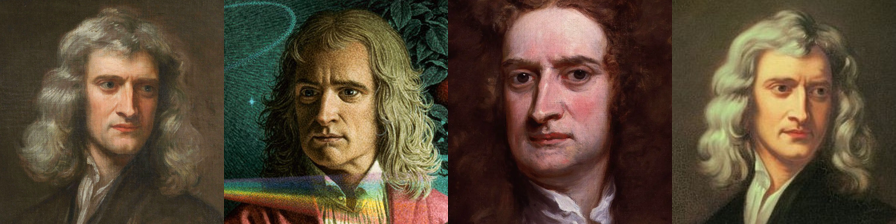

In [4]:
# define and show the input ID images
input_folder_name = './examples/newton_man'
image_basename_list = os.listdir(input_folder_name)
image_path_list = sorted([os.path.join(input_folder_name, basename) for basename in image_basename_list])

input_id_images = []
for image_path in image_path_list:
    id_image = load_image(image_path)
    # 获取原始图像的尺寸
    original_size = id_image.size
    # 计算新的尺寸（原来的一半）
    new_size = (original_size[0] // 4, original_size[1] // 4)
    # 调整图像大小
    resized_img = id_image.resize(new_size)
    input_id_images.append(id_image)

input_grid = image_grid(input_id_images, 1, 4, size_after_resize=224)
print("Input ID images:")
input_grid

In [5]:
## Note that the trigger word `img` must follow the class word for personalization
prompt = "sci-fi, closeup portrait photo of a man img wearing the sunglasses in Iron man suit, face, slim body, high quality, film grain"
negative_prompt = "(asymmetry, worst quality, low quality, illustration, 3d, 2d, painting, cartoons, sketch), open mouth"
generator = torch.Generator(device=device).manual_seed(42)

## Parameter setting
num_steps = 50
style_strength_ratio = 20
start_merge_step = int(float(style_strength_ratio) / 100 * num_steps)
if start_merge_step > 30:
    start_merge_step = 30

images = pipe(
    prompt=prompt,
    input_id_images=input_id_images,
    negative_prompt=negative_prompt,
    num_images_per_prompt=4,
    num_inference_steps=num_steps,
    start_merge_step=start_merge_step,
    generator=generator,
    height=512,
    width=512,
).images

 10%|█         | 5/50 [00:05<00:46,  1.03s/it]

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Results:


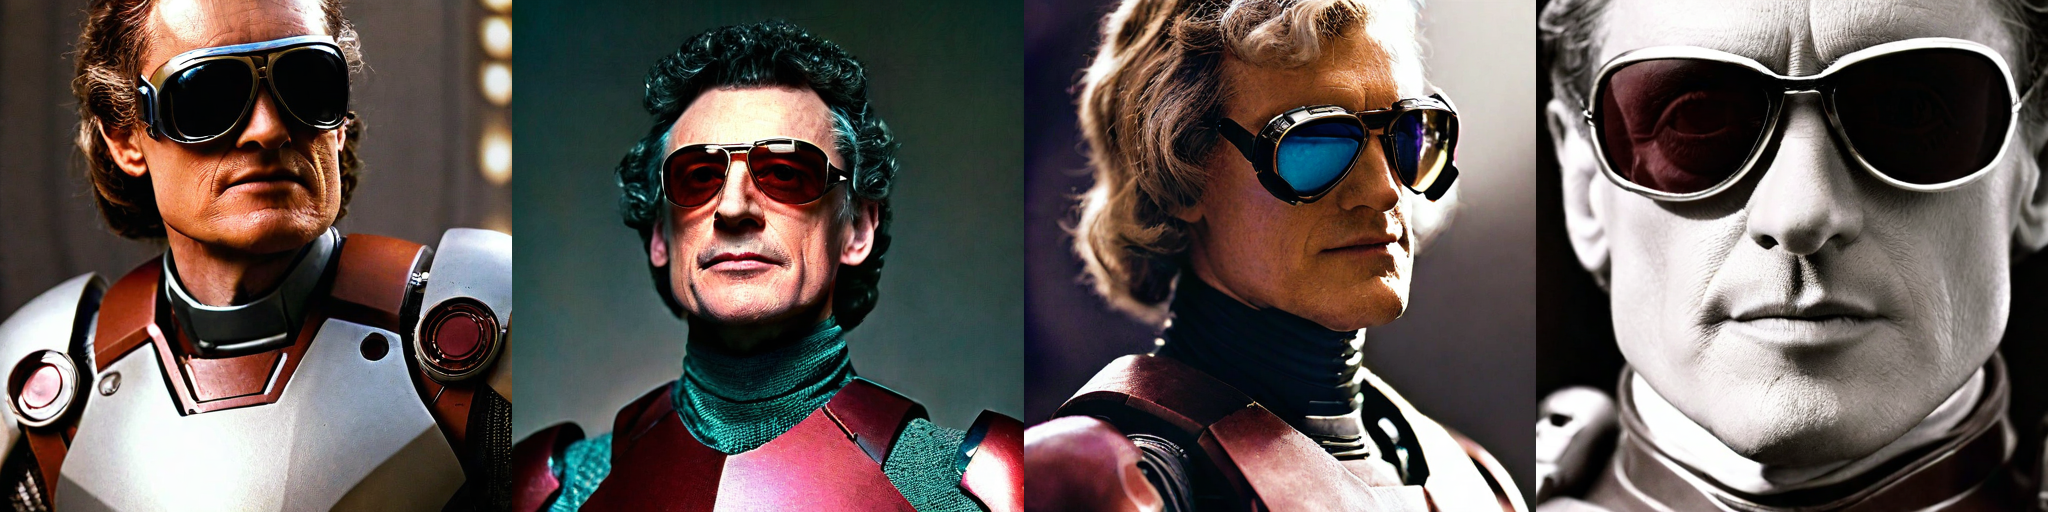

In [6]:
# Show and save the results
## Downsample for visualization
grid = image_grid(images, 1, 4, size_after_resize=512)

os.makedirs(save_path, exist_ok=True)
for idx, image in enumerate(images):
    image.save(os.path.join(save_path, f"photomaker_{idx:02d}.png"))

print("Results:")
grid